In [120]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_curve, auc, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sbn
import warnings
warnings.filterwarnings('ignore')

In [136]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModel.from_pretrained("xlm-roberta-base")

In [137]:
# Importando dataset
df = pd.read_csv(f'../datasets/b2w_preprocessed.csv')

In [138]:
df.shape

(71516, 2)

In [139]:
df.head(3)

,review_text,rating
0,recebi o produto antes do prazo mas veio com d...,0
1,nao compra este produto pois o mesmo veio com ...,0
2,tive azar pois o produto nao ligou tive que en...,0


In [140]:
# Dividindo dataset para testes em menores quantidades, não necessário caso use a base completa:
batch_1, batch_2 = train_test_split(df, test_size=0.5, stratify=df['rating'], random_state=42)
batch_3, batch_4 = train_test_split(batch_2, test_size=0.5, stratify=batch_2['rating'], random_state=42)
batch_5, batch_6 = train_test_split(batch_4, test_size=0.5, stratify=batch_4['rating'], random_state=42)
batch_7, batch_8 = train_test_split(batch_6, test_size=0.5, stratify=batch_6['rating'], random_state=42)
batch_9, batch_10 = train_test_split(batch_8, test_size=0.5, stratify=batch_8['rating'], random_state=42)
batch_11, batch_12 = train_test_split(batch_10, test_size=0.5, stratify=batch_10['rating'], random_state=42)
print(f'batch_01: {batch_1.shape}')
print(f'batch_02: {batch_2.shape}')
print(f'batch_03: {batch_3.shape}')
print(f'batch_04: {batch_4.shape}')
print(f'batch_05: {batch_5.shape}')
print(f'batch_06: {batch_6.shape}')
print(f'batch_07: {batch_7.shape}')
print(f'batch_08: {batch_8.shape}')
print(f'batch_09: {batch_9.shape}')
print(f'batch_10: {batch_10.shape}')
print(f'batch_11: {batch_11.shape}')
print(f'batch_12: {batch_12.shape}')

batch_01: (35758, 2)
batch_02: (35758, 2)
batch_03: (17879, 2)
batch_04: (17879, 2)
batch_05: (8939, 2)
batch_06: (8940, 2)
batch_07: (4470, 2)
batch_08: (4470, 2)
batch_09: (2235, 2)
batch_10: (2235, 2)
batch_11: (1117, 2)
batch_12: (1118, 2)


In [141]:
df = batch_12

In [142]:
df['rating'].value_counts()

rating
1    559
0    559
Name: count, dtype: int64

In [131]:
'''reviews = ['The cat sits outside',
             'I love pasta',
             'The cat plays in the garden',
             'Do you like pizza?']
labels = np.array([0,1,0,1])'''

"reviews = ['The cat sits outside',\n             'I love pasta',\n             'The cat plays in the garden',\n             'Do you like pizza?']\nlabels = np.array([0,1,0,1])"

In [143]:
reviews = df['review_text']
labels = np.array(df['rating'])

In [144]:
embeddings = []
attention_masks = []
for review in tqdm((reviews), desc="Processing"):
    inputs = tokenizer(
        str(review), 
        return_tensors="pt", 
        padding=True, 
        truncation=True,
        max_length=128
    )
    
    # capturando attentions masks
    attention_mask = inputs["attention_mask"]
    
    with torch.no_grad():
        output = model(**inputs)
    
    # adicionando embeddings tokenizados no array embeddings
    # média da última camada oculta
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())
    
    # adicionando attention masks no array attention_masks
    attention_masks.append(attention_mask.numpy())

Processing: 100%|██████████| 1118/1118 [02:32<00:00,  7.33it/s]


In [145]:
print(len(embeddings))
print(len(attention_masks))

1118
1118


In [146]:
embeddings_nparray = np.array(embeddings)

In [147]:
embeddings_nparray.shape

(1118, 1, 768)

In [148]:
# Feature based 2 - Concatena CLS, Med de todos, Std
# Calculando valores estatísticos:
cls_values = embeddings_nparray[:,0,:]
mean_values = np.mean(embeddings_nparray, axis=1)
std_values = np.std(embeddings_nparray, axis=1)

In [149]:
print(cls_values.shape)
print(mean_values.shape)
print(std_values.shape)

(1118, 768)
(1118, 768)
(1118, 768)


In [151]:
# Temos que ajusta a matrix de attention mask
attention_masks[0]

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1]])

In [152]:
# Ajustando attention mask matrix
max_columns = max(arr.shape[1] for arr in attention_masks)
combined_attention_masks_array = np.zeros((len(attention_masks), max_columns), dtype=np.int64)

for i, arr in enumerate(attention_masks):
    combined_attention_masks_array[i, :arr.shape[1]] = arr

print(combined_attention_masks_array)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [153]:
combined_attention_masks_array.shape

(1118, 128)

In [157]:
# Concatenando valores estatísticos e attention masks
combined_data = np.hstack((cls_values, mean_values, std_values, combined_attention_masks_array))

In [158]:
# Conferindo dimensões das matrizes
# Quantidade de instancias e dimensão do embedding
combined_data.shape

(1118, 2432)

In [161]:
labels.shape

(1118,)

In [162]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.2, random_state=42)

In [163]:
# Convertendo dados de treino em tensores do tensorflow
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Convertendo dados de teste em tensores do tensorflow
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [169]:
# Hiper-parâmetros:
HIDDEN_LAYER = 24
INPUT_DIM = X_train_tensor.shape[1]
DROPOUT = 0 #Dropout: 0, 10%
LEARNING_RATE = 2.5e-5 #Learning rate: 2.5e-5, 5e-5
OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [EARLY_STOP]
FOLDS = 10
EPOCHS = 5
BATCH_SIZE = 32
VERBOSE = 0

In [170]:
# Arquitetura de rede MLP
model = Sequential([
    Dense(HIDDEN_LAYER, activation='relu', input_dim=INPUT_DIM),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                58392     
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 58,417
Trainable params: 58,417
Non-trainable params: 0
_________________________________________________________________


In [171]:
# Compilando o modelo
model.compile(
    optimizer=OPTIMIZER, 
    loss=LOSS, 
    metrics=METRICS
)

In [172]:
# Cross-validation
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

In [173]:
# Treinando o modelo:

fold = 0

# -----------------------------------------------------------------------------

train_loss_history = []
train_accuracy_history = []

fold_train_losses = []
fold_train_accuracies = []
fold_train_f1_scores = []

train_tprs = []
train_aucs = []
train_mean_fpr = np.linspace(0, 1, 100)

# -----------------------------------------------------------------------------

fold_accuracies = []
fold_f1_scores = []

for train_indices, val_indices in tqdm((kf.split(combined_data)),desc="Processing"):
    fold+=1
    print(f'fold = {fold}')
    
    X_train_fold = combined_data[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_data[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
        
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        verbose=VERBOSE,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=CALLBACKS
    )
    
    # -----------------------------------------------------------------------------
    
    # train losses ecah fold
    fold_train_losses.append(model_history.history['val_loss'])
    
    # train accuracy each fold
    fold_train_accuracies.append(model_history.history['accuracy'])
    
    # train f1 score each fold
    y_pred_train = model.predict(X_train_fold_tensor)
    y_pred_train_binary = np.round(y_pred_train)
    fold_train_f1_scores.append(f1_score(y_train_fold_tensor, y_pred_train_binary))
    
    # train roc curve and auc
    fpr, tpr, thresholds = roc_curve(y_train_fold_tensor, y_pred_train)
    roc_auc = auc(fpr, tpr)
    train_tprs.append(np.interp(train_mean_fpr, fpr, tpr))
    train_aucs.append(roc_auc)
    
    # -----------------------------------------------------------------------------
    
    # val predictions
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    # val acc
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    # val f1
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    # val loss
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])
    
print('Finished train!')

Processing: 0it [00:00, ?it/s]

fold = 1
4/4 [==============================] - 0s 2ms/step


Processing: 1it [00:01,  1.65s/it]

fold = 2
4/4 [==============================] - 0s 3ms/step


Processing: 2it [00:02,  1.15s/it]

fold = 3
4/4 [==============================] - 0s 2ms/step


Processing: 3it [00:03,  1.02s/it]

fold = 4
4/4 [==============================] - 0s 1ms/step


Processing: 4it [00:04,  1.07it/s]

fold = 5
4/4 [==============================] - 0s 3ms/step


Processing: 5it [00:04,  1.12it/s]

fold = 6
4/4 [==============================] - 0s 2ms/step


Processing: 6it [00:05,  1.16it/s]

fold = 7
4/4 [==============================] - 0s 2ms/step


Processing: 7it [00:06,  1.18it/s]

fold = 8
4/4 [==============================] - 0s 2ms/step


Processing: 8it [00:07,  1.12it/s]

fold = 9
4/4 [==============================] - 0s 2ms/step


Processing: 9it [00:08,  1.11it/s]

fold = 10
4/4 [==============================] - 0s 2ms/step


Processing: 10it [00:09,  1.07it/s]

Finished train!


In [174]:
train_accuracy_mean_value = round(np.mean([np.mean(train_ac) for train_ac in fold_train_accuracies]),4)
train_f1_mean_value = round(np.mean([np.mean(train_f1) for train_f1 in fold_train_f1_scores]),4)
print(f"Media Accuracy Treino: {train_accuracy_mean_value}")
print(f"Media f1 score Treino: {train_f1_mean_value}")
print('-'*80)
print("Media Accuracy Validacao:", np.mean(fold_accuracies))
print("Media f1 score Validacao", np.mean(fold_f1_scores))

Media Accuracy Treino: 0.807
Media f1 score Treino: 0.8177
--------------------------------------------------------------------------------
Media Accuracy Validacao: 0.8148648648648649
Media f1 score Validacao 0.8093348035192968


In [175]:
def plot_eval_metrics(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.savefig(f'./graphs/tlm_gran_fb2_mlp_{metric}_train_test_{TRAIN_NUM}.png')
    plt.show()
    
def plot_train_folds(history, metric):
    plt.figure(figsize=(10, 6))
    for fold_num, fold_loss in enumerate(history):
        plt.plot(fold_loss, label=f'Fold {fold_num+1}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Training {metric}')
    plt.title(f'Training {metric} per Epoch for Each Fold')
    plt.legend()
    #plt.savefig(f'./graphs/tlm_gran_fb2_mlp_{metric}_train_loss_folds_test_{TRAIN_NUM}.png')
    plt.show()
    
def plot_roc_auc_curve(desc, mean_tpr, mean_auc):
    plt.figure()
    plt.plot(train_mean_fpr, mean_tpr, color='b', label=f'{desc} Mean ROC curve (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{desc} Mean Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    #plt.savefig(f'./graphs/tlm_gran_fb2_mlp_{desc}_train_roc_auc_curve_test_{TRAIN_NUM}.png')
    plt.show()
    
def plot_confunsion_matrix(cm):
    plt.figure(figsize=(6,4))
    sbn.heatmap(cm, annot=True, linewidth=0.2, annot_kws={'size':12}, fmt='.0f')
    plt.title("Matriz de Confusão", fontsize=12)
    plt.xlabel('Real')
    plt.ylabel('Predito')
    #plt.savefig(f'./graphs/tlm_gran_fb2_mlp_val_confusion_matrix_test_{TRAIN_NUM}.png')
    plt.show()

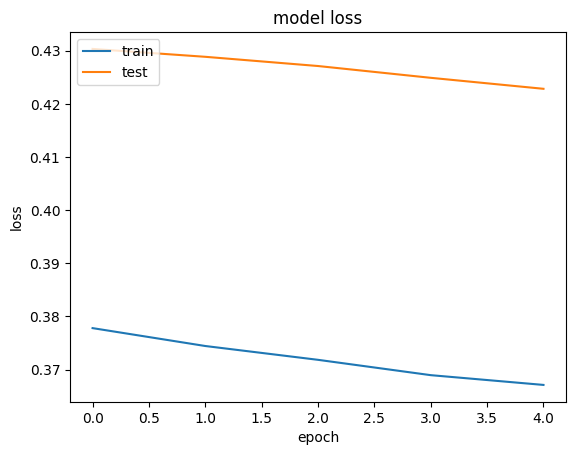

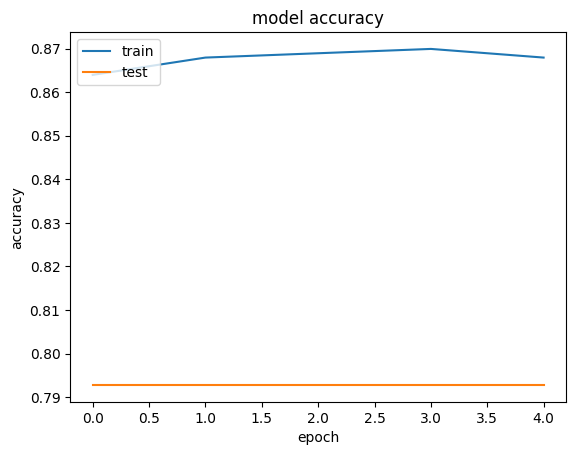

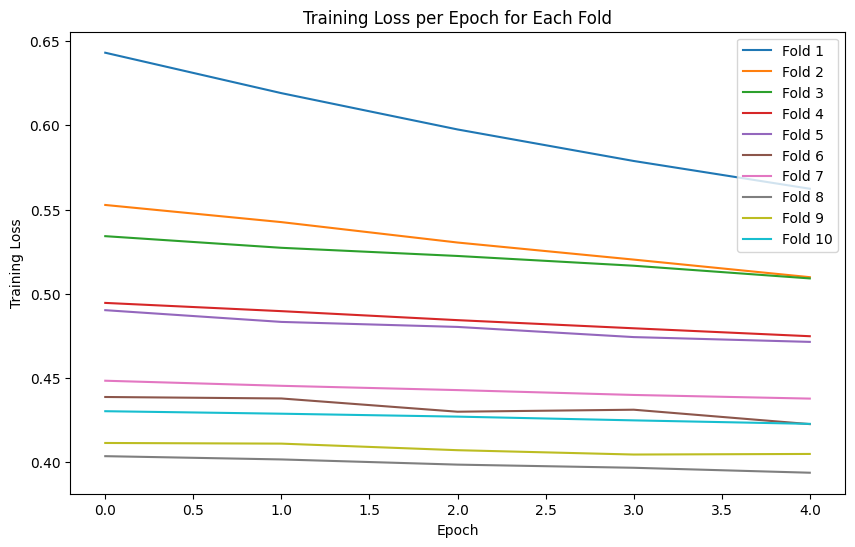

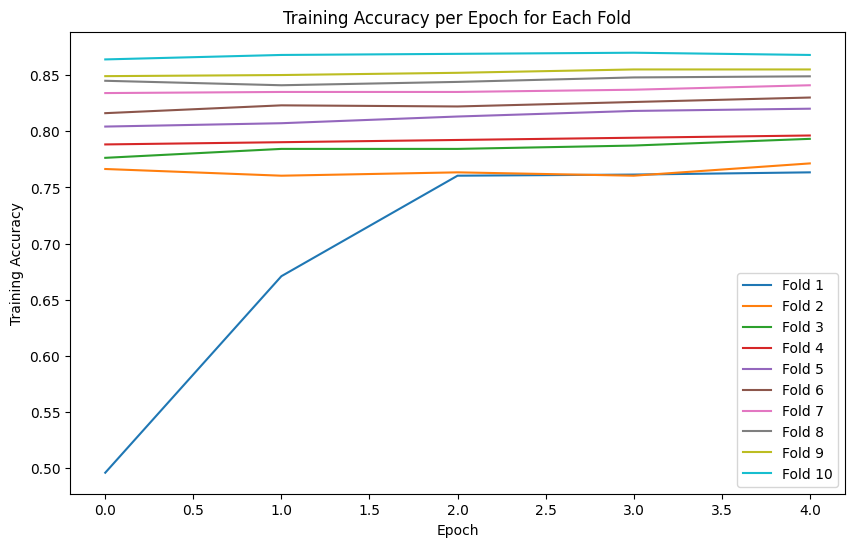

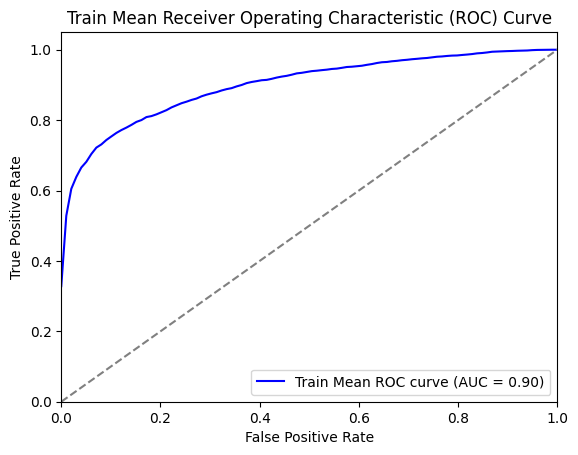

In [176]:
plot_eval_metrics(model_history, 'loss')
plot_eval_metrics(model_history, 'accuracy')

plot_train_folds(fold_train_losses, 'Loss')
plot_train_folds(fold_train_accuracies, 'Accuracy')

train_mean_tpr = np.mean(train_tprs, axis=0)
train_mean_auc = auc(train_mean_fpr, train_mean_tpr)
plot_roc_auc_curve('Train', train_mean_tpr, train_mean_auc)

In [177]:
predict = np.round(model.predict(X_val_fold_tensor))

4/4 [==============================] - 0s 2ms/step


In [178]:
accuracy = accuracy_score(y_val_fold_tensor, predict)
accuracy

0.7927927927927928

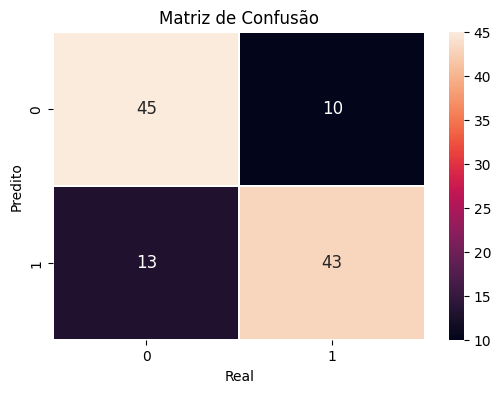

In [179]:
cm = confusion_matrix(y_val_fold_tensor, predict)
plot_confunsion_matrix(cm)